In [1]:
import joblib as jb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
import lightgbm
import sklearn

plt.rcdefaults()

# Package versions
print("Joblib version:", jb.__version__)
print("NumPy version:", np.__version__)
print("pandas version:", pd.__version__)
print("scikit-learn version:", sklearn.__version__)
print("lightgbm version:", lightgbm.__version__)
print("matplotlib version:", matplotlib.__version__)

Joblib version: 1.4.2
NumPy version: 1.26.4
pandas version: 2.2.3
scikit-learn version: 1.4.1.post1
lightgbm version: 4.5.0
matplotlib version: 3.10.0


In [2]:
# Loading data
data_per_year = jb.load("data_per_year.pkl")

In [3]:
# Preprocessing step for historic data from the clinic
# 1) No-show statistics
no_show_rate_cols = ['no_show_rate_last_1_day_in_MR',
       'median_no_show_rate_last_7_days_in_MR',
       'median_no_show_rate_last_30_days_in_MR',
       'quantile25_no_show_rate_last_7_days_in_MR',
       'quantile25_no_show_rate_last_30_days_in_MR',
       'quantile75_no_show_rate_last_7_days_in_MR',
       'quantile75_no_show_rate_last_30_days_in_MR',
       'mean_no_show_rate_last_7_days_in_MR',
       'mean_no_show_rate_last_30_days_in_MR',
       'min_no_show_rate_last_7_days_in_MR',
       'min_no_show_rate_last_30_days_in_MR',
       'max_no_show_rate_last_7_days_in_MR',
       'max_no_show_rate_last_30_days_in_MR',
       'std_no_show_rate_last_7_days_in_MR',
       'std_no_show_rate_last_30_days_in_MR',
       'no_show_rate_last_1_day_clinic_wide',
       'median_no_show_rate_last_7_days_clinic_wide',
       'median_no_show_rate_last_30_days_clinic_wide',
       'quantile25_no_show_rate_last_7_days_clinic_wide',
       'quantile25_no_show_rate_last_30_days_clinic_wide',
       'quantile75_no_show_rate_last_7_days_clinic_wide',
       'quantile75_no_show_rate_last_30_days_clinic_wide',
       'mean_no_show_rate_last_7_days_clinic_wide',
       'mean_no_show_rate_last_30_days_clinic_wide',
       'min_no_show_rate_last_7_days_clinic_wide',
       'min_no_show_rate_last_30_days_clinic_wide',
       'max_no_show_rate_last_7_days_clinic_wide',
       'max_no_show_rate_last_30_days_clinic_wide',
       'std_no_show_rate_last_7_days_clinic_wide',
       'std_no_show_rate_last_30_days_clinic_wide']

# 2) Demand statistics
demand_cols = ['demand_last_1_day_MR', 'median_demand_last_7_days_MR',
       'median_demand_last_30_days_MR', 'quantile25_demand_last_7_days_MR',
       'quantile25_demand_last_30_days_MR', 'quantile75_demand_last_7_days_MR',
       'quantile75_demand_last_30_days_MR', 'mean_demand_last_7_days_MR',
       'mean_demand_last_30_days_MR', 'min_demand_last_7_days_MR',
       'min_demand_last_30_days_MR', 'max_demand_last_7_days_MR',
       'max_demand_last_30_days_MR', 'std_demand_last_7_days_MR',
       'std_demand_last_30_days_MR', 'demand_last_1_day_clinic_wide',
       'median_demand_last_7_days_clinic_wide',
       'median_demand_last_30_days_clinic_wide',
       'quantile25_demand_last_7_days_clinic_wide',
       'quantile25_demand_last_30_days_clinic_wide',
       'quantile75_demand_last_7_days_clinic_wide',
       'quantile75_demand_last_30_days_clinic_wide',
       'mean_demand_last_7_days_clinic_wide',
       'mean_demand_last_30_days_clinic_wide',
       'min_demand_last_7_days_clinic_wide',
       'min_demand_last_30_days_clinic_wide',
       'max_demand_last_7_days_clinic_wide',
       'max_demand_last_30_days_clinic_wide',
       'std_demand_last_7_days_clinic_wide',
       'std_demand_last_30_days_clinic_wide']

# Corresponding PCA objects
pca_no_show = PCA(whiten=True, n_components=0.95)
pca_demand  = PCA(whiten=True, n_components=0.95)

# Preparing transformers list
transformers = [
    ("sex", SimpleImputer(strategy="most_frequent"), ["sex"]), # Just need to impute missing values
    ("PCA_no_show", pca_no_show, no_show_rate_cols),
    ("PCA_demand", pca_demand, demand_cols),
    ("numerical_no_indicator", Pipeline([
        ("standardize", StandardScaler()),
        ("impute", SimpleImputer(strategy="median")) # simple_imputer without missing indicator
    ]), ["age", "distance_to_clinic"]),
    ("numerical", Pipeline([
        ("standardize", StandardScaler()),
        ("impute", SimpleImputer(strategy="median", add_indicator=True)) # simple_imputer with missing indicator
    ]), ["waiting_time", "no_show_history", "today_demand_clinic_wide", "today_demand_MR"])
]

# Initializing ColumnTransformer
col_transformer = ColumnTransformer(transformers, remainder="passthrough")

# Wrapper to automatically create DataFrames after transforming data
class DFConverter(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cat_cols):
        self.transformer = transformer
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        # Get feature names
        self.feature_names_ = list(map(lambda c: c.split("__")[-1] if "pca" not in c else c, self.transformer.get_feature_names_out()))
        return self

    def transform(self, X):
        arr = self.transformer.transform(X)
        df = pd.DataFrame(arr, columns=self.feature_names_, index=X.index)
        # Converting data to categorical type
        for c in df.columns:
            if c in self.cat_cols:
                df[c] = df[c].astype("category")
            else:
                df[c] = df[c].astype("float")
        return df

# All categorical columns
cat_cols = ["sex", 'healthcare_plan', 'procedure', 'day_of_week', 'month', 'hour']

col_transformer = DFConverter(col_transformer, cat_cols)

In [4]:
# Classifier with the best set of hyperparameters
clf = LGBMClassifier(n_jobs=-1, verbosity=-1, n_estimators=3000, max_depth=63, colsample_bytree=0.7886372708925217,
                    scale_pos_weight=7.472410910017989, learning_rate=0.0007589929361363828, reg_alpha=0.0011885229743602958,
                    reg_lambda=0.7041794245156696)

# Final pipeline, including classifier
model_pipe = Pipeline([
    ("col_transformer", col_transformer),
    ("clf", clf)
])

In [5]:
def get_train_test(data_dict, test_year, initial_year):
    # Concatenate all data from initial_year up to the year before test_year
    train_years = list(range(initial_year, test_year))
    df_train = pd.concat([data_dict[year] for year in train_years])
    df_test = data_dict[test_year]

    # Separate features and target
    X_train = df_train.drop(columns=["no_show"]).reset_index(drop=True)
    y_train = df_train["no_show"].values
    X_test = df_test.drop(columns=["no_show"])
    y_test = df_test["no_show"].values

    # Return weight equal to number of training folds
    return X_train, y_train, X_test, y_test, len(train_years)

In [6]:
from sklearn.metrics import fbeta_score

test_years = [2016,2017,2018,2019,2020,2021,2022]
thresholds = np.round(np.arange(0.01, 1.0, 0.01), 3)
recall_precision_ratio = 1.5
fB_by_year = {year: [] for year in test_years}
for test_year in test_years:
    # Training and testing data
    X_train, y_train, X_test, y_test, weight = get_train_test(data_per_year, test_year, 2015)

    # Fitting model
    model_pipe.fit(X_train, y_train)

    # Predicting probability values
    y_pred_proba = model_pipe.predict_proba(X_test)
    
    for threshold in thresholds:
        y_pred = (y_pred_proba[:, 1] > threshold) * 1.0
        fB_by_year[test_year].append(fbeta_score(y_test, y_pred, beta=recall_precision_ratio))

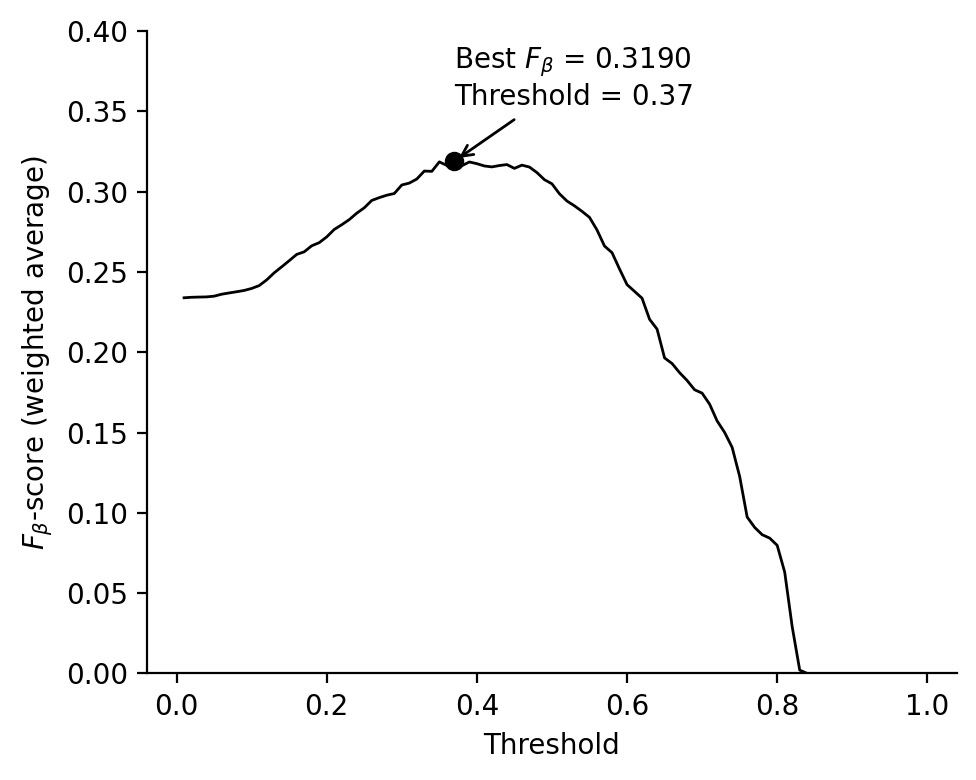

In [7]:
# Weights
weights = {year: year - 2015 for year in test_years}
total_weight = sum(weights.values())

# Weighted average for each threshold
weighted_avg = []
for i in range(len(thresholds)):
    numer = sum(weights[yr] * fB_by_year[yr][i] for yr in test_years)
    weighted_avg.append(numer / total_weight)

# Best threshold
idx_best = np.argmax(weighted_avg)
best_threshold = thresholds[idx_best]
best_fB = weighted_avg[idx_best]

# Plotting
plt.figure(figsize=(5, 4))
plt.plot(thresholds, weighted_avg, lw=1, color="black")
plt.scatter([best_threshold], [best_fB], color='black', zorder=5)
plt.annotate(
    rf'Best $F_\beta$ = {best_fB:.4f}' + f'\nThreshold = {best_threshold:.2f}',
    xy=(best_threshold, best_fB),
    xytext=(best_threshold, best_fB + 0.035),
    arrowprops=dict(arrowstyle='->', lw=1)
)

plt.xlabel('Threshold')
plt.ylabel(r'$F_\beta$-score (weighted average)')
plt.ylim(0, 0.4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("thresh_tun.png", dpi=400)
plt.show()